In [1]:
# Стандартні бібліотеки
import os
from typing import Any

# Зовнішні бібліотеки
import keras
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from IPython.display import display
from keras.callbacks import EarlyStopping
from keras.layers import Add, Conv2D
from keras.models import load_model
from keras.preprocessing.image import array_to_img, img_to_array
from keras.utils import image_dataset_from_directory
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes

In [2]:
print(f'TensorFlow version: {tf.__version__}')

TensorFlow version: 2.14.0


In [3]:
print(f"Доступні GPU: {tf.config.list_physical_devices('GPU')}")

Доступні GPU: []


In [4]:
channels = 1
cropped_width = 498
cropped_height = 300
upscale_factor = 3

input_width = cropped_width // upscale_factor
input_height = cropped_height  // upscale_factor

TEST_FOLDER_PATH  = 'D:\\KPI\\Bachelor_thesis\\code\\data\\images\\test'
TRAIN_FOLDER_PATH = 'D:\\KPI\\Bachelor_thesis\\code\\data\\images\\train'
VAL_FOLDER_PATH   = 'D:\\KPI\\Bachelor_thesis\\code\\data\\images\\val'

RAW_TEST_FOLDER_PATH  = 'D:\\KPI\\Bachelor_thesis\\code\\data\\raw_images\\test'
RAW_TRAIN_FOLDER_PATH = 'D:\\KPI\\Bachelor_thesis\\code\\data\\raw_images\\train'
RAW_VAL_FOLDER_PATH   = 'D:\\KPI\\Bachelor_thesis\\code\\data\\raw_images\\val'

In [5]:
print(f'Тестовий набір даних:')
test_set = image_dataset_from_directory(TEST_FOLDER_PATH, image_size=(cropped_width, cropped_height),
                                        batch_size=32, label_mode=None)
print(f'\nНавчальний набір даних:')
train_set = image_dataset_from_directory(TRAIN_FOLDER_PATH, image_size=(cropped_width, cropped_height),
                                         batch_size=32, label_mode=None)
print(f'\nВалідаційний набір даних:')
val_set = image_dataset_from_directory(VAL_FOLDER_PATH, image_size=(cropped_width, cropped_height),
                                       batch_size=32, label_mode=None)

Тестовий набір даних:
Found 66232 files belonging to 1 classes.

Навчальний набір даних:
Found 445929 files belonging to 1 classes.

Валідаційний набір даних:
Found 32968 files belonging to 1 classes.


In [6]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image
    
test_set = test_set.map(scaling)
train_set = train_set.map(scaling)
val_set = val_set.map(scaling)

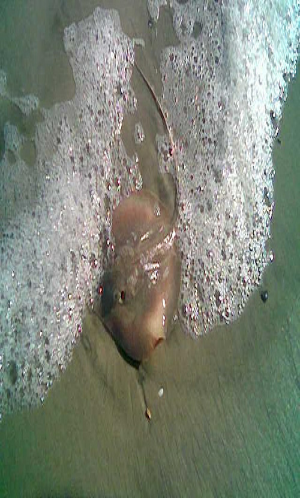

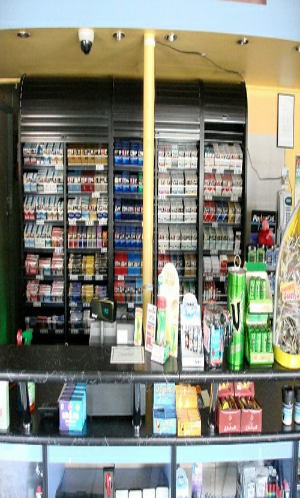

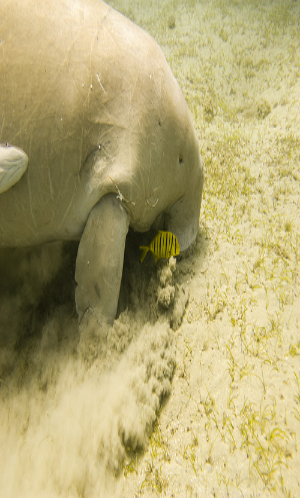

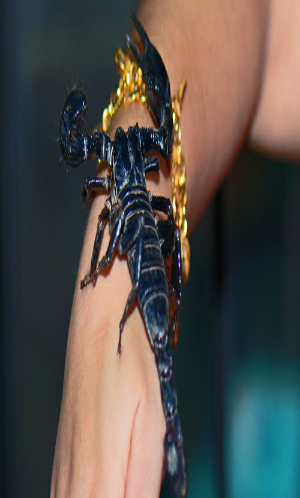

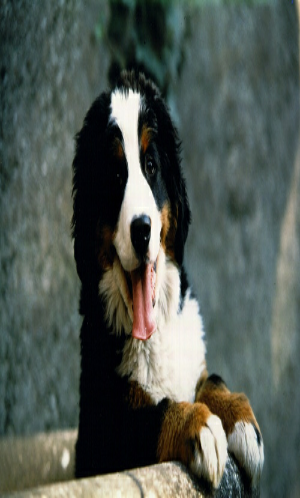

In [7]:
counter = 0
for batch in train_set.take(1):
    for img in batch:
        if counter < 5:
            display(array_to_img(img))
            counter += 1
        else:
            break

In [8]:
def process_features(input, new_width, new_height):
    input = tf.image.rgb_to_yuv(input)
    last_axis = len(input.shape) -1
    y, u, v = tf.split(input, 3, axis=last_axis)
    return tf.image.resize(y, [new_width, new_height], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_axis = len(input.shape) -1
    y, u, v = tf.split(input, 3, axis=last_axis)
    return y


test_set = test_set.map(lambda x: (process_features(x, input_width, input_height),process_target(x)))
train_set = train_set.map(lambda x: (process_features(x, input_width, input_height),process_target(x)))
val_set = val_set.map(lambda x: (process_features(x, input_width, input_height),process_target(x)))

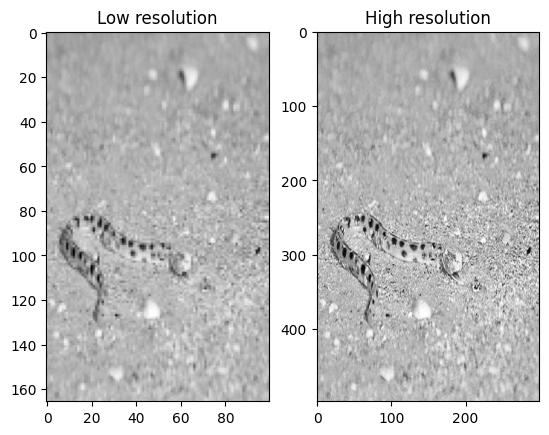

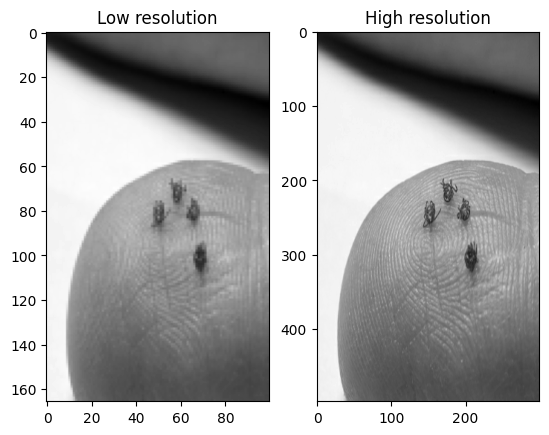

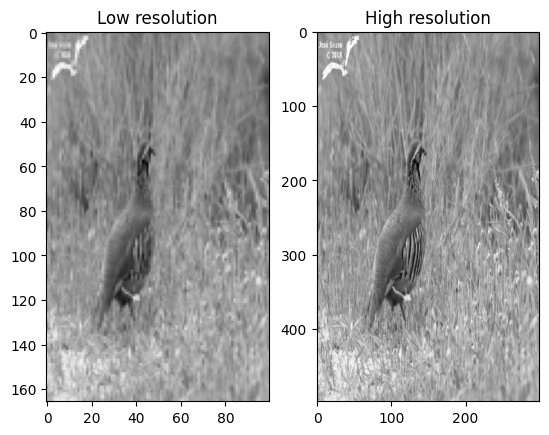

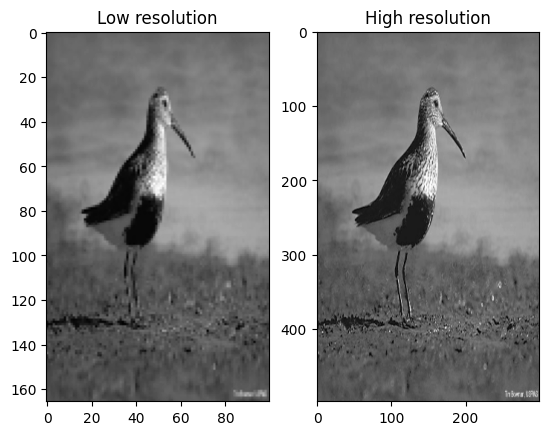

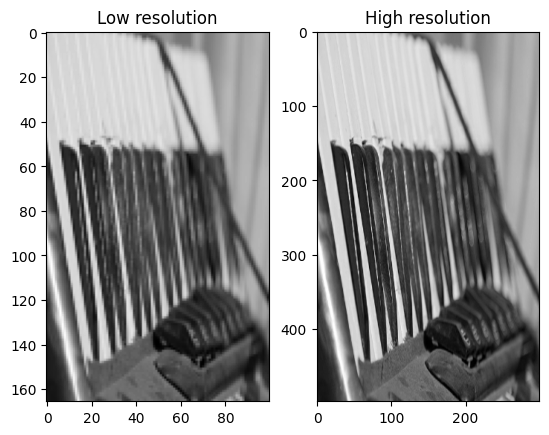

In [10]:
counter = 0
for batch in train_set.take(1):
    for img_lr, img_hr in zip(batch[0], batch[1]):
        if counter < 5:
            _fig, ax = plt.subplots(1, 2)
            ax[0].imshow(array_to_img(img_lr), cmap='gray')
            ax[0].set_title('Low resolution')
            ax[1].imshow(array_to_img(img_hr), cmap='gray')
            ax[1].set_title('High resolution')
            plt.show()
            counter += 1
        else:
            break


In [10]:
def rdb_block(inputs, numLayers):
    
    channels = inputs.get_shape()[-1]      # Get the amount of channels in our data, which is 1.
    
    storedOutputs = [inputs]
    
    for _ in range(numLayers):             # Here, "numLayers" represents the number of Conv2D layers
                                           # that are used for the RDB feature extraction process.
        localConcat = tf.concat(storedOutputs, axis=-1)
        
        out = Conv2D(filters=channels, kernel_size=3, padding="same",
            activation="relu")(localConcat)
        
        storedOutputs.append(out)               # The outputs of each Conv2D layer are appended.
        
    finalConcat = tf.concat(storedOutputs, axis=-1)
    finalOut = Conv2D(filters=channels, kernel_size=1,    # This Conv2D layer is called "pointwise"
        padding="same", activation="relu")(finalConcat)   # convolution layer. It basically prepares
                                                          # the data to be added to the original input
    finalOut = Add()([finalOut, inputs])                  # and exit the RDB block to enter the next
                                                          # layer in the CNN.
    return finalOut

In [11]:
def Model(channels, upscale_factor):

    inputs = keras.Input(shape=(None, None, channels))
    X = Conv2D(64, 5, padding='same', activation='relu', kernel_initializer='Orthogonal')(inputs)
    X = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='Orthogonal')(X)
    X = rdb_block(X, numLayers=3)
    X = Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='Orthogonal')(X)
    X = rdb_block(X, numLayers=3)
    X = Conv2D(channels * (upscale_factor**2), 3, padding='same', activation='relu', kernel_initializer='Orthogonal')(X)
    
    outputs = tf.nn.depth_to_space(X, upscale_factor)
    return keras.Model(inputs, outputs)

In [12]:
early_stopping = EarlyStopping(monitor='loss', patience=30, min_delta=0.0001)
model = Model(channels, upscale_factor)        
                                               # Adam optimizer due to its efficiency, MSE
model.compile(optimizer='adam', loss='MSE')    # loss function because it's a regression model.

model.summary()                                # Show a summary of the layers in our model.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 1)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 64)       1664      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 64)       36928     ['conv2d[0][0]']              
                                                                                                  
 tf.identity (TFOpLambda)    (None, None, None, 64)       0         ['conv2d_1[0][0]']            
                                                                                              

In [13]:
model.fit(train_set, epochs=500, callbacks= [early_stopping], validation_data = val_set)

model.save('D:\\KPI\\RDB_500_epochs.h5')
model.save('D:\\KPI\\RDB_500_epochs.keras')

Epoch 1/500
    1/11149 [..............................] - ETA: 144:46:42 - loss: 0.1813